# reference

https://github.com/Hwan-I/Study/blob/master/Recommend/Item-Based%20Collaborative%20Filtering%20Recommendation%20Algorithms/main.ipynb

# Prepare data and module

In [1]:
import pandas as pd
import numpy as np
import sklearn
from collections import defaultdict
from sklearn.linear_model import LinearRegression

In [2]:
ratings = pd.read_csv('./movie_data/u.data', sep='\t', header=None, names=['userId','movieId','rating','timestamp'])
ratings = ratings.drop('timestamp', axis=1)
ratings

,userId,movieId,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.2, random_state=1932)

In [4]:
movieIds = np.unique(train['movieId'])
userIds = np.unique(train['userId'])
print(f'movie 총 개수: {len(movieIds)}, user 총 수: {len(userIds)}')

movie 총 개수: 1652, user 총 수: 943


In [5]:
movieDict = defaultdict(dict) # [movieId][userId] = rating
userDict = defaultdict(dict) # [userId][movieId] = rating
userRatingMeanDict = defaultdict(dict) # [userId] = mean(rating)
movieRatingMeanDict = defaultdict(dict) # [movieId] = mean(rating)
coRatedMovieDict = defaultdict(dict) # [movieId1][movieId2] = [[movieId1r1, movieId1r2, ...], [movieId2r1, movieId2r2, ...]]
for i in train.index:
  userId = train._get_value(i, 'userId')
  movieId = train._get_value(i, 'movieId')
  rating = train._get_value(i, 'rating')
  movieDict[movieId][userId] = rating
  userDict[userId][movieId] = rating

for key in userDict.keys():
  userRatingMeanDict[key] = sum(userDict[key].values())/len(userDict[key].values())

for key in movieDict.keys():
  movieRatingMeanDict[key] = sum(movieDict[key].values())/len(movieDict[key].values())

for item1 in movieDict.keys():
  for item2 in movieDict.keys():
    if item1 == item2:
      continue
    d1 = movieDict[item1]
    d2 = movieDict[item2]
    coRatedMovieDict[item1][item2] = [[x, d1[x], d2[x]] for x in d1 if x in d2]


# cosine similarity

In [ ]:
def get_correlation_similarity(coRatedRi, coRatedRj):
  I = np.array(coRatedRi)
  J = np.array(coRatedRj)
  I_norm = np.sqrt(np.sum(np.square(I)))
  J_norm = np.sqrt(np.sum(np.square(J)))
  K = np.dot(I,J) / (I_norm * J_norm)
  return 0 if np.isnan(K) else K

In [6]:
cosineSimilarityDict = defaultdict(dict) # [item1][item2] = sim
for item1 in movieDict.keys():
  for item2 in movieDict.keys():
    if item1 >= item2:
      continue
    numer = 0.
    denom1 = 0.
    denom2 = 0.
    for [userId, rating1, rating2] in coRatedMovieDict[item1][item2]:
      numer += rating1*rating2
      denom1 += rating1**2
      denom2 += rating2**2
    if numer*denom1*denom2==0:
      continue
    cosineSimilarityDict[item1][item2] = numer / ((denom1**0.5) * (denom2**0.5))
    cosineSimilarityDict[item2][item1] = cosineSimilarityDict[item1][item2]

In [ ]:
cosineSimilarityDict[1][2]

# correlation similarity

In [ ]:
def get_correlation_similarity(coRatedRi, coRatedRj):
  R_i = np.array(coRatedRi)
  R_j = np.array(coRatedRj)
  I = R_i-np.mean(R_i)
  J = R_j-np.mean(R_j)
  I_norm = np.sqrt(np.sum(np.square(I)))
  J_norm = np.sqrt(np.sum(np.square(J)))
  K = np.dot(I,J) / (I_norm * J_norm)
  return 0 if np.isnan(K) else K

In [7]:
correlationSimilarityDict = defaultdict(dict)
for item1 in movieDict.keys():
  for item2 in movieDict.keys():
    if item1 >= item2:
      continue
    numer = 0.
    denom1 = 0.
    denom2 = 0.
    for [userId, rating1, rating2] in coRatedMovieDict[item1][item2]:
      I = rating1-movieRatingMeanDict[item1]
      J = rating2-movieRatingMeanDict[item2]
      numer += I*J
      denom1 += I**2
      denom2 += J**2
    if numer*denom1*denom2==0:
      correlationSimilarityDict[item1][item2] = 0.
    else:
      correlationSimilarityDict[item1][item2] = numer / ((denom1**0.5) * (denom2**0.5))
    correlationSimilarityDict[item2][item1] = correlationSimilarityDict[item1][item2]

In [ ]:
correlationSimilarityDict[1][2]

# adjusted cosine similarity

In [ ]:
def get_adjusted_cosine_similarity(coRatedRi, coRatedRj, RuMean):
  R_i = np.array(coRatedRi)
  R_j = np.array(coRatedRj)
  I = R_i-RuMean
  J = R_j-RuMean
  I_norm = np.sqrt(np.sum(np.square(I)))
  J_norm = np.sqrt(np.sum(np.square(J)))
  K = np.dot(I,J) / (I_norm * J_norm)
  return K

In [8]:
adjustedCosineSimilarityDict = defaultdict(dict)
for item1 in movieDict.keys():
  for item2 in movieDict.keys():
    if item1 >= item2:
      continue
    numer = 0.
    denom1 = 0.
    denom2 = 0.
    for [userId, rating1, rating2] in coRatedMovieDict[item1][item2]:
      I = rating1-userRatingMeanDict[userId]
      J = rating2-userRatingMeanDict[userId]
      numer += I*J
      denom1 += I**2
      denom2 += J**2
    if numer*denom1*denom2==0:
      adjustedCosineSimilarityDict[item1][item2] = 0.
    else:
      adjustedCosineSimilarityDict[item1][item2] = numer / ((denom1**0.5) * (denom2**0.5))
    adjustedCosineSimilarityDict[item2][item1] = adjustedCosineSimilarityDict[item1][item2]

In [ ]:
adjustedCosineSimilarityDict[1][2]

# utils

In [9]:
similarityDicts = [cosineSimilarityDict, correlationSimilarityDict, adjustedCosineSimilarityDict]

In [10]:
def get_k_neighbor_dict(similarityDict, K):
  kSimilarityDict = defaultdict(dict)
  for i in movieIds:
    temp = sorted(similarityDict[i].items(), key=(lambda x:x[1]), reverse=True)
    if K != 0:
      temp = temp[:K]
    dict_ = {}
    for j in range(len(temp)):
        dict_[temp[j][0]] = temp[j][1]
    kSimilarityDict[i] = dict_
  return kSimilarityDict

In [11]:
kSimilarityDicts = [get_k_neighbor_dict(similarityDict, 0) for similarityDict in similarityDicts]

In [79]:
# 각 item i의 가장 유사한 item N를 알아낸다
# 둘의 coRatedMovieDict[i][N]을 구한다
# regression을 돌려준다
from sklearn.linear_model import LinearRegression

regRatingDicts = {0: defaultdict(dict), 1: defaultdict(dict), 2: defaultdict(dict)}
for j in range(3):
  ksd = kSimilarityDicts[j]
  regRatingDict = regRatingDicts[j]
  for i in movieIds:
    similarMovieId = list(ksd[i].keys())[0]
    if not coRatedMovieDict[i][similarMovieId]:
      continue
    users, Ri, Rn = np.array(coRatedMovieDict[i][similarMovieId]).T
    lineFitter = LinearRegression()
    lineFitter.fit(Ri.reshape(-1, 1), Rn.reshape(-1, 1))
    
#     regR = lineFitter.predict([[1.],[1.5],[2.],[2.5],[3.],[3.5],[4.],[4.5],[5.]])
    
#     regRatingDict[i] = dict(list(zip(['1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0'], np.array(regR).squeeze())))
    if userRatingMeanDict[i] == {}:
      continue
    regRatingDict[i] = np.array(lineFitter.predict([[userRatingMeanDict[i]]])).squeeze()


In [106]:
regRatingDicts[0][602]

array(3.83333333)

# prediction

In [68]:
def pred(u, i, kSimilarityDict):
  movieRatings = userDict[u] # [movieId] = rating
  movieSimilarity = kSimilarityDict[i] # [movieId] = similarity

  plus_mean = 0.
  if u in userRatingMeanDict:
    plus_mean = userRatingMeanDict[u]
  else:
    plus_mean = sum(userRatingMeanDict.items())/len(userRatingMeanDict.items())
  ratedSimilarMovie = [[movieRatings[x], movieSimilarity[x]] for x in movieRatings if x in movieSimilarity]
  
  similarityMulRating = list(map(lambda x: (x[0]-plus_mean)*x[1], ratedSimilarMovie))
  absoluteSimilarity = list(map(lambda x: abs(x[1]), ratedSimilarMovie))
  
  if sum(absoluteSimilarity)==0:
    return plus_mean
  p = sum(similarityMulRating)/sum(absoluteSimilarity)+plus_mean

  return min(max(p, 1.), 5.)

In [ ]:
pred(1, 1, kSimilarityDicts[1])

In [117]:
def pred_reg(u, i, kSimilarityDict, regRatingDict):  
  movieRatings = userDict[u] # [movieId] = rating
  movieSimilarity = kSimilarityDict[i] # [movieId] = similarity
  
  plus_mean = 0.
  if u in userRatingMeanDict:
    plus_mean = userRatingMeanDict[u]
  else:
    plus_mean = sum(userRatingMeanDict.items())/len(userRatingMeanDict.items())
    
  if regRatingDict[i]=={}:
    return plus_mean
  ratedSimilarMovie = [[regRatingDict[i], movieSimilarity[x]] for x in movieRatings if x in movieSimilarity]
  
  similarityMulRating = list(map(lambda x: (x[0]-plus_mean)*x[1], ratedSimilarMovie))
  absoluteSimilarity = list(map(lambda x: abs(x[1]), ratedSimilarMovie))
  
  if sum(absoluteSimilarity)==0:
    return plus_mean
  p = sum(similarityMulRating)/sum(absoluteSimilarity)+plus_mean

  return min(max(p, 1.), 5.)

In [ ]:
pred_reg(1, 3, 10, 'adjusted_cosine')

# evaluation

In [69]:
mae = []
for i in test.index:
  userId = test._get_value(i, 'userId')
  movieId = test._get_value(i, 'movieId')
  rating = test._get_value(i, 'rating')
  row = []
  for dic in kSimilarityDicts:
    p = pred(userId, movieId, dic)
    row.append(abs(p-rating))
  mae.append(row)

In [70]:
np.mean(mae, axis=0)

array([0.83680257, 0.81012093, 0.75271649])

In [118]:
mae_reg = []
for i in test.index:
  userId = test._get_value(i, 'userId')
  movieId = test._get_value(i, 'movieId')
  rating = test._get_value(i, 'rating')
  row = []
  for j in range(3):
    p = pred_reg(userId, movieId, kSimilarityDicts[j], regRatingDicts[j])
    row.append(abs(p-rating))
  mae_reg.append(row)

In [119]:
np.mean(mae_reg, axis=0)

array([1.13515243, 1.16213039, 0.87169094])

# visualization

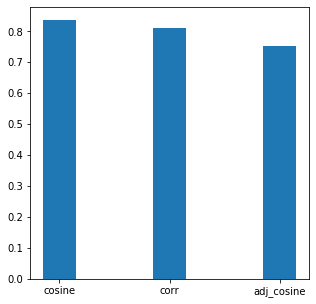

In [84]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.bar(['cosine','corr','adj_cosine'],np.mean(mae, axis=0),  width=0.3)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.bar(['cosine','corr','adj_cosine'], np.mean(mae_reg, axis=0),  width=0.3)
plt.show()

# testing

In [91]:
class itemBasedCollaborativeFiltering:
  def __init__(self, df, testSize, K):
    self.train, self.test = train_test_split(df, test_size=testSize, random_state=1932)
    self.movieIds = movieIds = np.unique(self.train['movieId'])
    self.userIds = np.unique(self.train['userId'])
    self.movieDict, self.userDict = self.get_item_dict()
    self.userRatingMeanDict = self.get_user_rating_mean_dict()
    self.movieRatingMeanDict = self.get_movie_rating_mean_dict()
    self.coRatedMovieDict = self.get_co_rated_movie_dict()
    
    self.adjustedCosineSimilarityDict = self.get_adjusted_cosine_similarity_dict()
    
    self.kSimilarityDict = self.get_k_neighbor_dict(self.adjustedCosineSimilarityDict, K)

  def get_item_dict(self):
    movieDict = defaultdict(dict) # [movieId][userId] = rating
    userDict = defaultdict(dict) # [userId][movieId] = rating
    for i in self.train.index:
      userId = self.train._get_value(i, 'userId')
      movieId = self.train._get_value(i, 'movieId')
      rating = self.train._get_value(i, 'rating')
      movieDict[movieId][userId] = rating
      userDict[userId][movieId] = rating
    return movieDict, userDict
  
  def get_user_rating_mean_dict(self):
    userRatingMeanDict = defaultdict(dict) # [userId] = mean(rating)
    for key in self.userDict.keys():
      userRatingMeanDict[key] = sum(self.userDict[key].values())/len(self.userDict[key].values())
    return userRatingMeanDict

  def get_movie_rating_mean_dict(self):
    movieRatingMeanDict = defaultdict(dict) # [movieId] = mean(rating)
    for key in self.movieDict.keys():
      movieRatingMeanDict[key] = sum(self.movieDict[key].values())/len(self.movieDict[key].values())
    return movieRatingMeanDict

  def get_co_rated_movie_dict(self):
    coRatedMovieDict = defaultdict(dict) # [movieId1][movieId2] = [[movieId1r1, movieId1r2, ...], [movieId2r1, movieId2r2, ...]]
    for item1 in self.movieDict.keys():
      for item2 in self.movieDict.keys():
        if item1 == item2:
          continue
        d1 = movieDict[item1]
        d2 = movieDict[item2]
        coRatedMovieDict[item1][item2] = [[x, d1[x], d2[x]] for x in d1 if x in d2]
    return coRatedMovieDict
  
  def get_adjusted_cosine_similarity_dict(self):
    adjustedCosineSimilarityDict = defaultdict(dict)
    for item1 in self.movieDict.keys():
      for item2 in self.movieDict.keys():
        if item1 >= item2:
          continue
        numer = 0.
        denom1 = 0.
        denom2 = 0.
        for [userId, rating1, rating2] in self.coRatedMovieDict[item1][item2]:
          userRatingMean = 3.
          if userId in self.userRatingMeanDict:
            userRatingMean = self.userRatingMeanDict[userId]
          I = rating1-userRatingMean
          J = rating2-userRatingMean
          numer += I*J
          denom1 += I**2
          denom2 += J**2
        if numer*denom1*denom2==0:
          adjustedCosineSimilarityDict[item1][item2] = 0.
        else:
          adjustedCosineSimilarityDict[item1][item2] = numer / ((denom1**0.5) * (denom2**0.5))
        adjustedCosineSimilarityDict[item2][item1] = adjustedCosineSimilarityDict[item1][item2]
    return adjustedCosineSimilarityDict
  
  def get_k_neighbor_dict(self, similarityDict, K):
    kSimilarityDict = defaultdict(dict)
    for i in self.movieIds:
      temp = sorted(similarityDict[i].items(), key=(lambda x:x[1]), reverse=True)
      if K != 0:
        temp = temp[:K]
      dict_ = {}
      for j in range(len(temp)):
          dict_[temp[j][0]] = temp[j][1]
      kSimilarityDict[i] = dict_
    return kSimilarityDict
  
  def predict(self, u, i, kSimilarityDict):
    movieRatings = self.userDict[u] # [movieId] = rating
    movieSimilarity = kSimilarityDict[i] # [movieId] = similarity

    plus_mean = 3.
    if u in self.userRatingMeanDict:
      plus_mean = self.userRatingMeanDict[u]
#     else:
#       plus_mean = sum(self.userRatingMeanDict.items())/len(self.userRatingMeanDict.items())
    ratedSimilarMovie = [[movieRatings[x], movieSimilarity[x]] for x in movieRatings if x in movieSimilarity]

    similarityMulRating = list(map(lambda x: (x[0]-plus_mean)*x[1], ratedSimilarMovie))
    absoluteSimilarity = list(map(lambda x: abs(x[1]), ratedSimilarMovie))

    if sum(absoluteSimilarity)==0:
      return plus_mean
    p = sum(similarityMulRating)/sum(absoluteSimilarity)+plus_mean

    return min(max(p, 1.), 5.)
  
  def getMAE(self):
    mae = []
    for i in test.index:
      userId = test._get_value(i, 'userId')
      movieId = test._get_value(i, 'movieId')
      rating = test._get_value(i, 'rating')
      p = self.predict(userId, movieId, self.kSimilarityDict)
      mae.append(abs(p-rating))
    return np.mean(mae, axis=0)

In [92]:
MAEs = []
for ts in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
  model = itemBasedCollaborativeFiltering(ratings, ts, 0)
  MAEs.append(model.getMAE())
  print(f'test ratio: {ts}, done')

test ratio: 0.2, done
test ratio: 0.3, done
test ratio: 0.4, done
test ratio: 0.5, done
test ratio: 0.6, done
test ratio: 0.7, done
test ratio: 0.8, done
test ratio: 0.9, done


In [93]:
MAEs

[0.7527164880100984,
 0.7536551453348845,
 0.7554764650943493,
 0.7588777312687206,
 0.7617624009572391,
 0.7677147945089222,
 0.7829934303172457,
 0.8256890983850684]

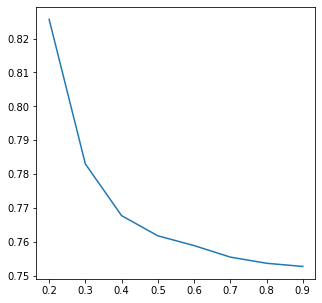

In [100]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9][::-1],MAEs[::-1])
plt.show()

In [ ]:
MAEs_neighbor = []
for neighborNum in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200]:
  model = itemBasedCollaborativeFiltering(ratings, 0.2, neighborNum)
  MAEs_neighbor.append(model.getMAE())
  print(f'neighbor num: {neighborNum}, done')

In [ ]:
MAEs_neighbor